Introduction to wavelet theory
=========
by Christopher Schölzel

Author's Note:
---------------
I use this notebook to keep notes about my learning process about wavelet theory.
I hope that these notes may help somebody else in their learning process, but as I am not an expert myself, they may of course contain errros.
If you spot such an error, please let me know. 

My main learning resource currently is "Ten lectures on wavelets" by Ingrid Daubechies[[1]](#ref1). I will therefore probably mostly follow the structure of this book.

<a name="ref1">[1]</a> [Daubechies, I. Ten lectures on Wavelets. (Society for industrial and applied mathematics, 1992).](http://dx.doi.org/10.1137/1.9781611970104)


What is a wavelet?
---------------
So... what exactly are these "wavelets" everybody is talking about? Well, just as a piglet is a small pig, a wavelet is - essentially - a small wave. A very simple example of such small wave is the mexican hat function:

$$m(x) = \frac{2}{\sqrt{3 \sigma} \pi^{\frac{1}{4}}} \left(1-\frac{x^2}{\sigma^2}\right) e^{\frac{-x^2}{2 \sigma^2}}$$

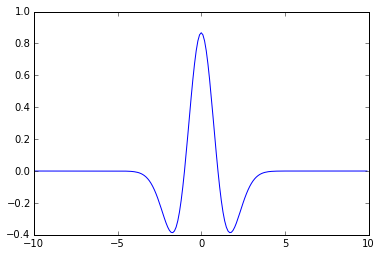

In [50]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def mexican_hat(x, mu, sigma):
    return 2 / (np.sqrt(3 * sigma) * np.pi**0.25) * (1 - x**2 / sigma**2) * np.exp(-x**2 / (2 * sigma**2) )

xvals = np.arange(-10,10,0.1)
plt.plot(xvals, mexican_hat(xvals, 0, 1))
plt.show()

The mexican hat function/wavelet is the rescaled negative second derivative of the gaussian function (the probability distribution function of the normal distribution).

$$
g(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{- (x-mu)^2}{2 \sigma^2}}
$$

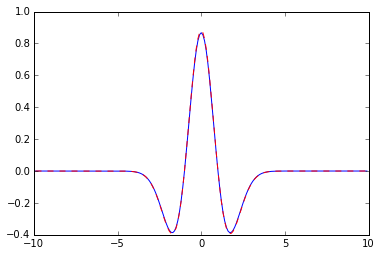

In [51]:
def gauss(x, mu, sigma):
    return 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

g = gauss(xvals, 0, 1)
m = mexican_hat(xvals, 0, 1)
dg = g[1:] - g[:-1] # linear approximation of first derivative
ddg = dg[1:] - dg[:-1] # linear approximation of second derivative

plt.plot(xvals, m, "b-")
fac = m[len(xvals)//2] / -ddg[len(xvals)//2] # scaling factor
plt.plot(xvals[1:-1], -ddg*fac, "r--")
plt.show()

In fact, there are no theoretical limitations to what a wavelet can be. However, for practical purposes, "standard" wavelets, like the mexican hat wavelet, have some desirable properties.
* The integral of a wavelet should be finite.
* For the mexican hat wavelet, the integral is even zero, which means that a convolution with this function will leave the output signal in the same value range as the input signal.

In [52]:
np.sum(m)

0.0

Wavelet theory and the Fourier transform
-----------------------

The wavelet transform is often linked to the fourier transform, because both are used to inspect the frequency spectrum of a signal.

To examine the similarities and differences between the fourier and wavelet transform we will generate some artificial sound data:

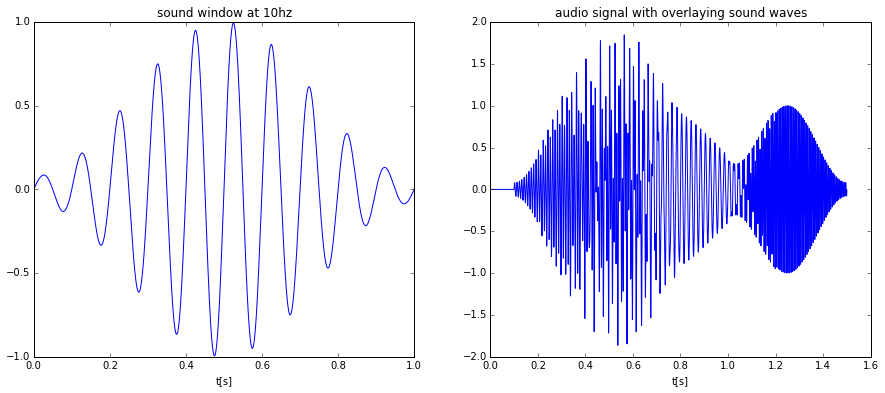

In [53]:
def hamming(n):
    """ Hamming window of size N for smoothing the edges of sound waves """
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(n) / (n-1))

def sound(freq, dur, res=10000):
    ln = dur*res
    sound = np.zeros(ln)
    sound = np.sin(np.arange(ln)*2*np.pi*freq/res)
    return sound * hamming(ln)

def add_sound(audio, loc, freq, dur, res=10000):
    audio[loc:loc+dur*res] += sound(freq, dur, res=res)

res = 10000 # sound resolution in hz
plt.figure(figsize=(15,6))
plt.subplot(121)
snd = sound(10,1)
plt.plot(np.arange(len(snd),dtype="float32")/res,snd)
plt.xlabel("t[s]")
plt.title("sound window at 10hz")

plt.subplot(122)
audio = np.zeros(15000)
add_sound(audio, 1000, 100, 0.5)
add_sound(audio, 3000, 130, 0.5)
add_sound(audio, 2000, 50, 1)
add_sound(audio, 10000, 150, 0.5)
plt.plot(np.arange(len(audio),dtype="float32")/res,audio)
plt.xlabel("t[s]")
plt.title("audio signal with overlaying sound waves")

plt.show()

Now that we have our sample data, we can look at its power spectrum using the fourier transform.

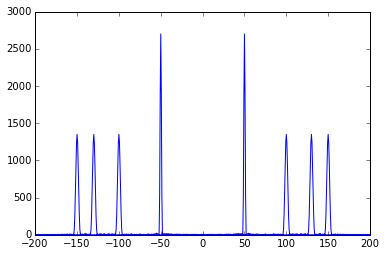

In [54]:
fourier = np.fft.fft(audio)
xvals = np.fft.fftfreq(len(audio))*res
idx = np.where(np.abs(xvals) < 200)
plt.plot(xvals[idx],np.abs(fourier)[idx])
plt.show()

As expected, we see clear peaks at the frequencies that are present in the data (50 hz, 100 hz, 130 hz, and 150 hz).
However, the fourier transform leaves us with no information _where_ these frequencies occurred in the original signal.

For the analysis of sound-related data (and many other types of data with spatial information) it would be desirable to retain this spatial information.
With the fourier transform, we can multiply the original signal with a window function so that we only get the frequency components within that window.
By shifting the window over the signal, we get the information of all frequency bands at all locations.
This technique is called the *windowed Fourier transform*.

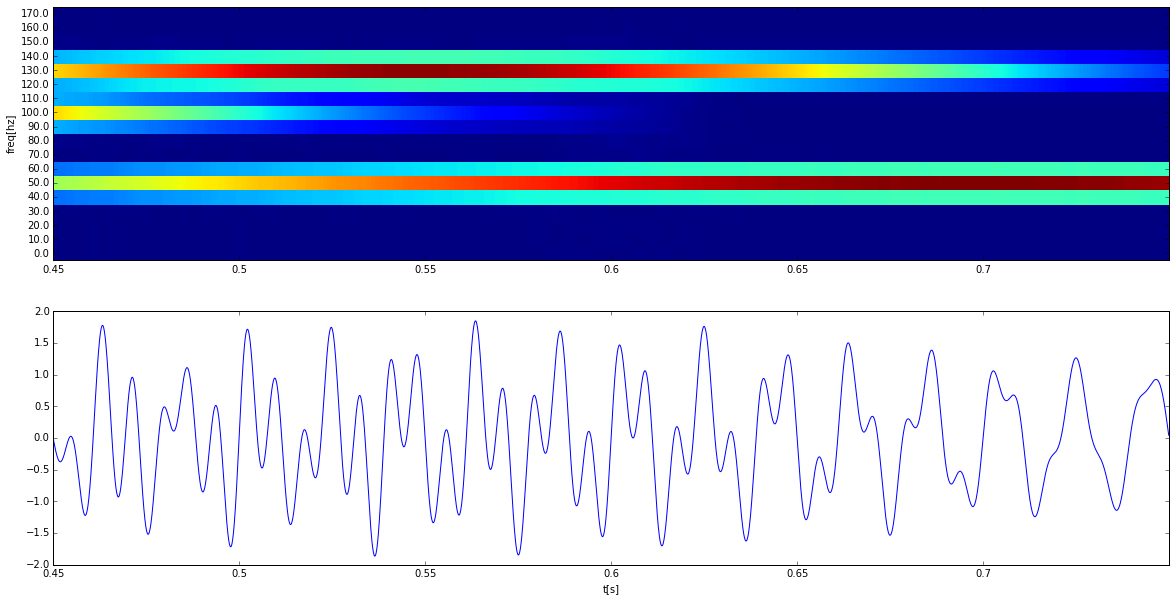

In [115]:
# note: the execution of this code block might take a few seconds
def fourier_w(signal, window_size=1000):
    out = np.zeros((len(signal),window_size))
    window = hamming(window_size)
    for i in range(window_size//2, len(signal)-window_size//2):
        s = i - window_size//2
        e = s + window_size
        wsig = signal[s:e] * window
        out[i,:] = np.abs(np.fft.fft(wsig))
    return out

s,e = 4000,8000 # range of signal
wsize = 1000 # window size
fs,fe = 0,18 # range of frequencies to plot

fw = fourier_w(audio[s:e],window_size=wsize)
fwcut = fw[wsize//2:-wsize//2,fs:fe]
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.pcolormesh(fwcut.T)
yt = np.arange(0,len(fwcut[0]),1)
plt.yticks(yt+0.5,(np.fft.fftfreq(wsize)*res)[yt+fs])
xt = np.arange(0,len(fwcut),wsize//2)
plt.xticks(xt,(xt+s+wsize//2)/res)
plt.ylabel("freq[hz]")
plt.ylim(0,len(fwcut[0]))

plt.subplot(212)
plt.plot(audio[s+wsize//2:e-wsize//2])
plt.xticks(xt, (xt+s+wsize//2)/res)
plt.xlabel("t[s]")
plt.show()

As you can see from the plots above, the windowed fourier transform preserves the spatial information at the cost of a higher computational complexity.
We can see that the 100hz sound fades out at t = 0.6s, which is exactly what we defined: The sound starts at t = 0.1s and has a duration of 0.5s.

The (discrete) wavelet transform essentially aims to solve the same problem as the windowed fourier transform: It provides information about the frequency spectrum without losing the spatial location.

At this point, we could use an existing implementation of the discrete wavelet transform and compare its output to that of the windowed fourier transform.
If you are interested in a ready-to-use version of the DWT for python, I suggest you have a look at Machine Learning PYthon ([mlpy](http://mlpy.sourceforge.net/docs/3.1/index.html)) or PyWavelets ([pywt](http://www.pybytes.com/pywavelets/ref/dwt-discrete-wavelet-transform.html)).
I have not yet tested any of those packages, but they both seem quite mature at first glance.
In this notebook we will take the hard approach of building a dwt for ourselves and understanding it step by step.
We may come back to this example when we are finished with that. ;)

In order to do this, it may first help to recall what the fourier transformation is actually doing.
We therefore define functions that calculate the fourier coefficients manually by multiplying the signal with a sine- and cosine-wave and taking the integral of the result (by summing all values):

In [141]:
def fourier_coeff_i(signal, freq, res=10000):
    """ calculates the imaginary fourier coefficient of signal at frequency freq """
    s = -np.sin(np.arange(len(signal))*2*np.pi*freq/res) # sine wave with given frequency
    return np.sum(signal * s) # integral

def fourier_coeff_r(signal, freq, res=10000):
    """ calculates the real fourier coefficient of signal at frequency freq """
    s = np.cos(np.arange(len(signal))*2*np.pi*freq/res) # sine wave with given frequency
    return np.sum(signal * s) # integral

freqs = [50,70,100,110,120,125,130,140,150]
faudio = np.fft.fft(audio)
fbins = np.fft.fftfreq(len(audio))
coeff_lib = lambda f: faudio[int(np.floor(f/res*len(audio)))]
for f in freqs:
    i = fourier_coeff_i(audio,f)
    r = fourier_coeff_r(audio,f)
    print("{0:3d}hz: {1:5.0f} + {2:5.0f}i (fft: {3.real:5.0f} {3.imag:+5.0f}i)".format(f,r,i,coeff_lib(f)))

 50hz:    -0 + -2700i (fft:    -0 -2700i)
 70hz:    -0 +    -0i (fft:    -0    -0i)
100hz:    -0 + -1350i (fft:    -0 -1350i)
110hz:     0 +    -0i (fft:     0    -0i)
120hz:    -0 +    -0i (fft:    -0    -0i)
125hz:    12 +    -0i (fft:    -3    +3i)
130hz:    -0 + -1350i (fft:    -0 -1350i)
140hz:     0 +    -0i (fft:     0    -0i)
150hz:     0 + -1350i (fft:     0 -1350i)


Now, to introduce the time domain again, we define a function that calculates a single coefficient of the windowed fourier transform for a given time and frequency:

In [147]:
def windowed_fourier(signal, freq, t, wsize=1000, res = 10000):
    window = hamming(wsize)
    s = int(np.floor(t * res - wsize//2))
    wsig = signal[s:s+wsize] * window
    return [f(wsig, freq, res=res) for f in [fourier_coeff_r, fourier_coeff_i]]

args = [
    (50,0.5),
    (50,0.7),
    (150,0.6),
    (150,1.2)
]
for f, t in args:
    r, i = windowed_fourier(audio, f, t)
    print("{0:3d}hz, {1:5.3f}s: {2:+5.0f} {3:+5.0f}i".format(f, t, r, i))

 50hz, 0.500s:    +1  +184i
 50hz, 0.700s:    -1  +269i
150hz, 0.600s:    -2    +1i
150hz, 1.200s:    -0  +243i


With this definition we have a function that can tell us for each frequency at each point in time how much of that frequency is present in our signal.
How would this function look for the wavelet transform?

Well, actually it looks really similar, except that the wavelet is constructed in such a way that the multiplication with the window and the sine/cosine wave is replaced by a convolution of the original signal with the wavelet.
(Remember: Wavelets like the mexican hat wavelet already have a "windowed" shape that drops to zero to both sides.)

Mathematically, the wavelet transform can be defined as follows:

$$
(T^{\text{wav}} f)(a,b) = \sqrt{|a|} \int dt \; f(t) \psi \left(\frac{t-b}{a}\right)
$$

where $a$ is the scale and relates to the frequency f while b is the location parameter relating to the time t.

With this definition, we can take a quick glance how the wavelet transform with a mexican hat wavelet might look like:


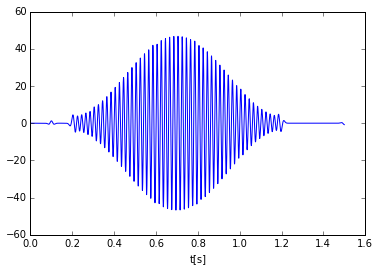

In [216]:
# note the response of a mexican hat wavelet of 1s length is highest for a frequency of approximately 4hz
def twav(signal, f):
    wav = mexican_hat(np.arange(-5,5,10.0/10000 * f/4.0), 0, 1)
    return np.convolve(signal, wav, "same")

# remember: the sound at 50hz starts at t = 0.2s and has a duration of 1s
plt.plot(np.arange(len(audio))/res,twav(audio,50))
plt.xlabel("t[s]")
plt.show()

As you can see, the wavelet transform with the mexican hat function also filters frequency information and retains spatial information.
The response of the transform at 50hz shows where the corresponding sound begins and ends, but the transformed signal also oscillates so that we do not get a clear spectrum.
For higher frequencies, you can also see that the response overlays with the other frequency bands that are nearby.
This is probably because the mexican hat function does not fit the sine waves in the signal perfectly, whereas the sine waves used in the fourier transform do.

However, before we further investigate the theory of the wavelet transform, I would like to return one (probably) last time to the Fourier transform.
It turns out, that the fourier transform for a given frequency can also be interpreted as a convolution much like the wavelet transform.
The only change we need to make is to mirror our windowed sine- and cosine waves at the y axis to counteract the mirroring in the convolution operation.

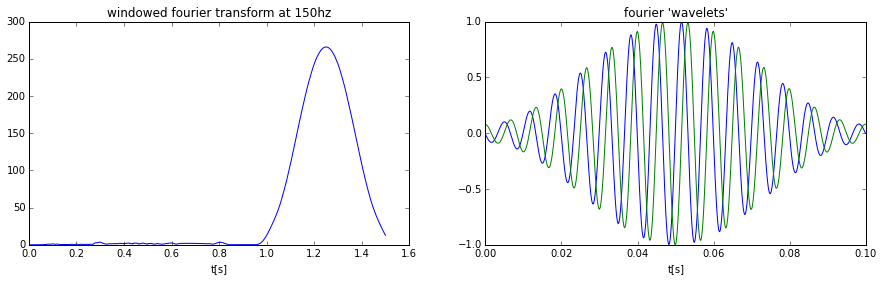

In [218]:
def wfourier_conv(signal, freq, wsize=1000, res=10000):
    window = hamming(wsize)
    x = (wsize-1-np.arange(wsize)) * 2 * np.pi * freq / res
    swindow = window * np.sin(x)
    cwindow = window * np.cos(x)
    sfft, cfft = [np.convolve(signal,x,"same") for x in [swindow, cwindow]]
    return swindow, cwindow, cfft - sfft * 1j 

# remember: we have issued a sound with 150hz at t = 1s with duration 5s
sw150, cw150, f150 = wfourier_conv(audio, 150, res=res)
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(np.arange(len(audio),dtype="float32")/res,np.abs(f150))
plt.title("windowed fourier transform at 150hz")
plt.xlabel("t[s]")

plt.subplot(122)
plt.plot(np.arange(len(sw150),dtype="float32")/res,sw150)
plt.plot(np.arange(len(cw150),dtype="float32")/res,cw150)
plt.title("fourier 'wavelets'")
plt.xlabel("t[s]")
plt.show()
    